In [1]:
## Initialize ##
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import scipy.special as scsp
import random as rand
from scipy.optimize import fsolve
import os
from tqdm import tqdm
from class_carbon_gambling import *
from colorsarr import colorsarr #For the colormap
colarr = colorsarr()
carr = colarr.carr
cd = os.getcwd()

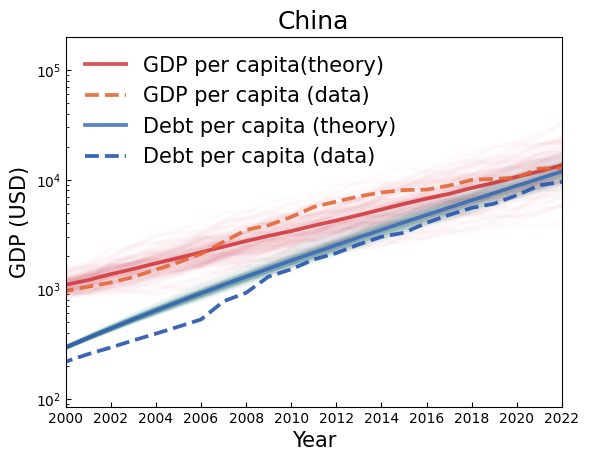

In [6]:
## GDP and Debt ##

country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years

##DATA##
#For US
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/gdp-per-capita
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/debt-to-gdp-ratio
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/usa/united-states/population
    # between 1980 and 2023 in millions USD

#For France
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/gdp-per-capita
    # Between 1998 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/debt-to-gdp-ratio
    # Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/fra/france/population
    # Between 1980 and 2022 #https://countryeconomy.com/deficit/france

#For Denmark
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/gdp-per-capita
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/population
    #Between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/dnk/denmark/debt-to-gdp-ratio https://www.imf.org/external/datamapper/DEBT1@DEBT/GRC?zoom=GRC&highlight=GRC
    #From 1980 https://countryeconomy.com/deficit/denmark

#For China
    #between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/gdp-per-capita
    #between 1960 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/gdp-per-capita
    # Between 1984 and 2022 #https://www.macrotrends.net/global-metrics/countries/chn/china/debt-to-gdp-ratio
    # Between 1982 and 2022 #https://countryeconomy.com/national-debt/china

GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #Actual data for GDP
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Actual data for debt
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Actual data for population
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Actual data for deficit
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]
length=tflist.size-1

title = r'Minimal modeling of GDP and debt in ' + 'the US' if country == 'US' else str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
# Create the colormap
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist)

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
rep = 100
avgGDP = 0.
avgdebt = 0.
GDP0 = GDPpercapitalist[0] #Initial GDP per capita
L = np.mean(levlist) #Average leverage
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita

for i in range(rep):
    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt)
    model.evol()
    GDP = np.array(model.Clist) #GDP from stochastic model
    debt = np.array(model.Dlist) #Debt from stochastic model
    avgGDP += GDP
    avgdebt += debt
    ax1.plot(firstyear+tflist, GDP, lw = 2.7, alpha = 2./rep, c=cmapphase(0.1))
    ax1.plot(firstyear+tflist, debt, lw = 2.7, alpha = 2./rep, c=cmapphase(0.67))

avgGDP = avgGDP/rep
ax1.plot(firstyear+tflist, avgGDP, lw = 2.7, alpha = 0.8, c=cmapphase(0.15), label=r'GDP per capita(theory)')
ax1.plot(firstyear+tflist, GDPpercapitalist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(0.07), label=r'GDP per capita (data)') #[sum(GDPlist[:i]) for i in tflist]

avgdebt = avgdebt/rep
ax1.plot(firstyear+tflist, avgdebt, lw = 2.7, alpha = 0.8, c=cmapphase(0.7), label=r'Debt per capita (theory)')
ax1.plot(firstyear+tflist, debtpercapitalist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(0.73), label=r'Debt per capita (data)') #[sum(debtpercaplist[:i]) for i in tflist]

ax1.legend(fontsize=15, loc='best', frameon=False)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'GDP (USD)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_xlim(firstyear+2, 2022)
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.set_ylim(inidebt/2,2E5)
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/GDP_data'+country+'.pdf')

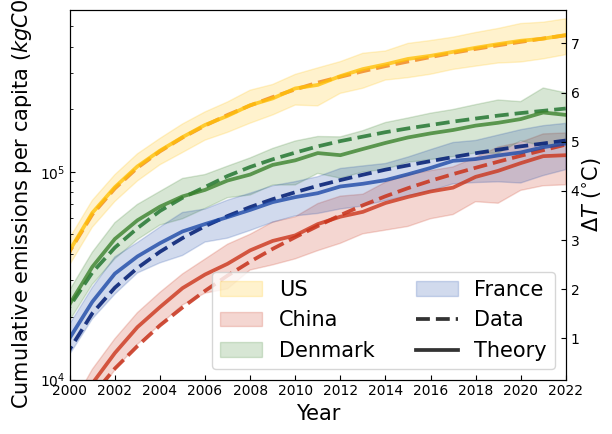

In [7]:
#all countries#
## Integrated emissions ##

temp = True
countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years

title = r'Effect of debt on $CO_2$ emissions'
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[0] #Initial GDP per capita
    L = np.mean(levlist) #Average leverage
    rho = np.mean(rholist) #Average interest rate
    meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
    sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
    inidebt = debtpercapitalist[0] #Initial debt per capita
    Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
    gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity
    
    ax1.plot(firstyear+tflist, [sum(Emperyearlist[:i]) for i in tflist], lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05))#, label=r'$\mathcal{E}_{\text{per capita}}$ (data)' if n==0 else None)

    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
    rep = 100 #Number of repetitions
    avgEm = 0.
    avgEmdiff = 0.
    stdsqr = 0.
    for i in range(rep):
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False)[0] for tf in tflist])
        emissionsdiff = np.array([emissions[tf+1] - emissions[tf] for tf in tflist[:-1]])
        emissionsdiff = np.array([(emissionsdiff[min(tf+1, len(tflist)-2)] + emissionsdiff[tf])/2. for tf in tflist[:-1]])
        avgEm += emissions #Update average
        avgEmdiff += emissionsdiff #Update standard deviation
        stdsqr += np.array([(emissions[tf] - avgEm[tf]/(i+(i==0)))**2 for tf in tflist])
    avgEm = avgEm/rep
    avgEmdiff = avgEmdiff/rep
    stdsqr = np.sqrt(stdsqr/rep)
    ax1.plot(firstyear+tflist, avgEm, lw = 2.7, alpha = 0.8, c=cmapphase(n/4))
    ax1.fill_between(firstyear+tflist, avgEm - stdsqr, avgEm + stdsqr, color=cmapphase(n/4), alpha=0.2, label=str.upper(country[0]) + country[1:]) #Standard deviation from stochasticity

ylimmin, ylimmax = 1E4, 6E5
ax1.plot(0, 0, lw = 2.7, ls='--', alpha = 0.8, c='black', label = 'Data')
ax1.plot(0, 0, lw = 2.7, alpha = 0.8, c='black', label = 'Theory')
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)

ax1.legend(fontsize=15, loc='lower right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgC0_2$)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_data_all.pdf')

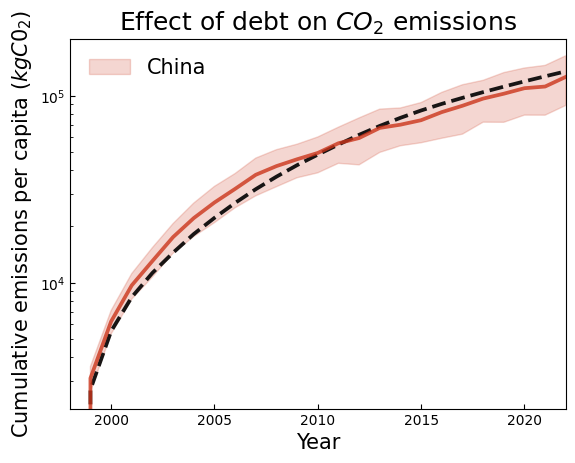

In [8]:
## Integrated emissions for single countries##

country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:]
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[0] #Initial GDP per capita
L = np.mean(levlist) #Average leverage
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita
Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)

ax1.plot(firstyear+tflist, [sum(Emperyearlist[:i]) for i in tflist], lw = 2.7, alpha = 0.9, ls='--', c='black')#, label=r'$\mathcal{E}_{\text{per capita}}$ (data)' if n==0 else None)

model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
rep = 100 #Number of repetitions
avgEm = 0.
avgEmdiff = 0.
stdsqr = 0.
for i in range(rep):
    emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False)[0] for tf in tflist])
    emissionsdiff = np.array([emissions[tf+1] - emissions[tf] for tf in tflist[:-1]])
    emissionsdiff = np.array([(emissionsdiff[min(tf+1, len(tflist)-2)] + emissionsdiff[tf])/2. for tf in tflist[:-1]])
    avgEm += emissions #Update average
    avgEmdiff += emissionsdiff #Update standard deviation
    stdsqr += np.array([(emissions[tf] - avgEm[tf]/(i+(i==0)))**2 for tf in tflist])
avgEm = avgEm/rep
avgEmdiff = avgEmdiff/rep
stdsqr = np.sqrt(stdsqr/rep)
ax1.plot(firstyear+tflist, avgEm, lw = 2.7, alpha = 0.8, c=cmapphase(1/4))
ax1.fill_between(firstyear+tflist, avgEm - stdsqr, avgEm + stdsqr, color=cmapphase(1/4), alpha=0.2, label=str.upper(country[0]) + country[1:]) #Standard deviation from stochasticity


ax1.set_xlim(firstyear,2022)
ax1.legend(fontsize=15, loc='upper left', frameon=False)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgC0_2$)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_data'+country+'.pdf')

/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_7355/2524340536.py:46: RuntimeWarning: invalid value encountered in scalar divide
  datapdIlist = np.array([np.sum(Emperyearlist[:tau])/(np.sum(GDPpercapitalist[:tau])) for tau in tflist]) #Data for path dependent intensity list from 0 to duration-1
/var/folders/88/nhwhjjhs73j3_587yk930r480000gp/T/ipykernel_7355/2524340536.py:61: RuntimeWarning: invalid value encountered in scalar divide
  pdIlist = np.array([emissionscum[tau]/GDPcum[tau] for tau in range(np.size(em,0) )]) #Path dependent intensity list


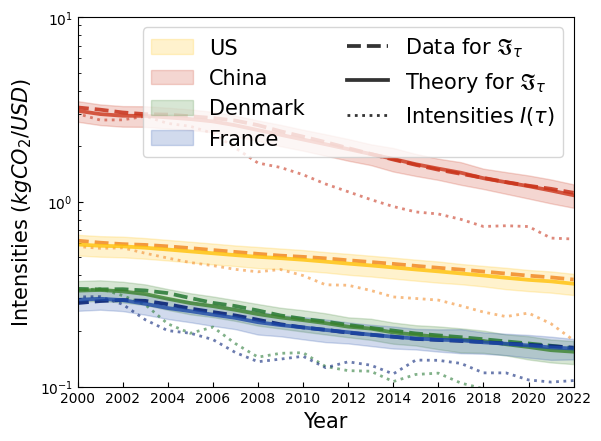

In [ ]:
## Lock-in effect and path dependent intenbsities##

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create colormap

duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, True #True to show temperature variation on right axis, True to use a logscale for y axis
countries = ['US', 'china', 'denmark', 'france'] #Different countries to study

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ##Initial conditions##
    GDP0 = GDPpercapitalist[0] #Initial GDP per capita
    L = np.mean(levlist) #Average leverage
    rho = np.mean(rholist) #Average interest rate
    meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
    sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
    inidebt = debtpercapitalist[0] #Initial debt per capita
    Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1

    datapdIlist = np.array([np.sum(Emperyearlist[:tau])/(np.sum(GDPpercapitalist[:tau])) for tau in tflist]) #Data for path dependent intensity list from 0 to duration-1
    ax1.plot(firstyear + tflist, datapdIlist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05))
    ax1.plot(firstyear + tflist, Emintensitylist, lw = 2., alpha = 0.6, ls=':', c=cmapphase(n/4+0.05))
    
    model = kelly_debt(5, L, GDP0, 100, rho, duration-1, gaussian=True, W = meanW, sig=sigW, borroweachstep=True, D0 = inidebt) #Stochastic model
    rep = 100 #Number of repetitions
    avgpdI = 0. #Initiate average path dependent intensity
    em = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False) for tf in tflist])
    emissionscum = np.array([em[tau][0] for tau in range(np.size(em,0) )]) #Cumulated emissions
    GDPcum = np.array([em[tau][1] for tau in range(np.size(em,0) )]) #Cumulated GDP
    stdsqr = 0. #Initiate standard deviation for path dependent intensity
    for i in range(rep):
        em = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = False) for tf in tflist])
        emissionscum = np.array([em[tau][0] for tau in range(np.size(em,0) )]) #Cumulated emissions
        GDPcum = np.array([em[tau][1] for tau in range(np.size(em,0) )]) #Cumulated GDP
        pdIlist = np.array([emissionscum[tau]/GDPcum[tau] for tau in range(np.size(em,0) )]) #Path dependent intensity list
        avgpdI += pdIlist #Update average
        stdsqr += np.array([(pdIlist[tau] - avgpdI[tau]/(i+(i==0)))**2 for tau in range(np.size(pdIlist))]) #Update standard deviation
    avgpdI = avgpdI/rep
    stdsqr = np.sqrt(stdsqr/rep)
    ax1.plot(firstyear+tflist, avgpdI, lw = 2.7, alpha = 0.8, c=cmapphase(n/4))
    ax1.fill_between(firstyear+tflist, avgpdI - stdsqr, avgpdI + stdsqr, color=cmapphase(n/4), alpha=0.2, label=str.upper(country[0]) + country[1:])

ylimmin, ylimmax = 1E-1, 1E1
ax1.plot(0, 0, lw = 2.7, ls='--', alpha = 0.8, c='black', label = r'Data for $\mathfrak{I}_{\tau}$')
ax1.plot(0, 0, lw = 2.7, alpha = 0.8, c='black', label = r'Theory for $\mathfrak{I}_{\tau}$')
ax1.plot(0, 0, lw = 2., ls = ':', alpha = 0.8, c='black', label = r'Intensities $I(\tau)$')
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)

title = 'Path-dependent intensities'
ax1.legend(fontsize=15, loc='upper right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Intensities ($kgCO_2/USD$)', fontsize=15)
ax1.margins(x=0)
ax1.set_yscale('log')
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')

fig1.savefig(cd + '/results/lockin_pathdepint_all.pdf')

100%|██████████| 5/5 [00:00<00:00, 598.43it/s]


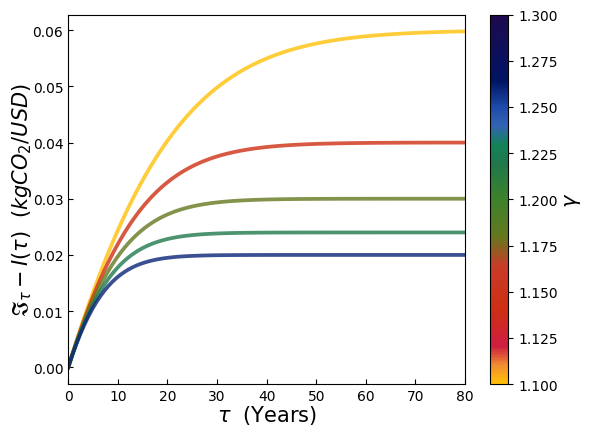

In [28]:
## Difference between path dependent intensity and yearly intensity ##

eta = 0.006 #Absolute value of the linear slope for the dependency of yearly intensities on time in kgCO2/USD/year
def deltaI(gam,tau):
    return eta*(tau + gam*( (tau+1.)*gam**tau - tau*gam**(tau+1.) - 1. )/((gam - 1.)*(gam**(tau+1) - 1.))) #Analytical difference between intensities

gamlist = [1.1, 1.15, 1.2, 1.25, 1.3] #List of deterministic growth rates

fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
ax1.set_xlabel(r'$\tau$  (Years)', labelpad=0, fontsize=15)
ax1.set_ylabel(r'$\mathfrak{I}_{\tau} - I(\tau)$  $(kgCO_2/USD)$', labelpad=-1, fontsize=15)

clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=gamlist[0], vmax=gamlist[-1], clip=False)

taulist = np.linspace(0., 80., 100) #List of time in years
for i, gam in enumerate(tqdm(gamlist)):
    ax1.plot(taulist, deltaI(gam, taulist), lw = 2.7, alpha = 0.8, c=cmapphase(i/len(gamlist)))
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$\gamma$')
cbar.set_label(r'$\gamma$', size=15)
ax1.margins(x=0)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + r'/results/diffI_vs_tau.pdf')

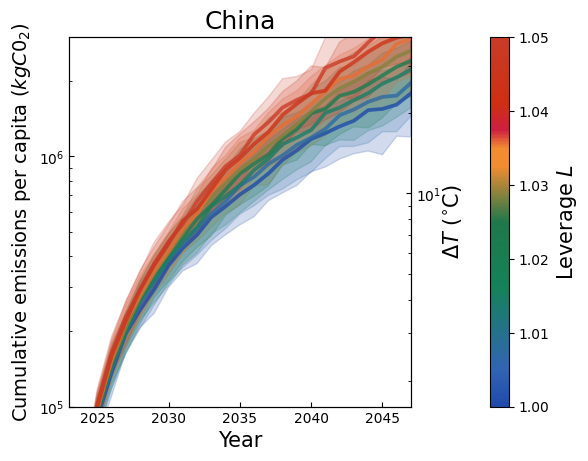

In [32]:
## Predicted cumulative emissions ##
country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, True #True to show temperature variation on right axis, True to use a logscale for y axis

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:] 
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1]
rho = np.mean(rholist)
meanW = np.mean(np.log(1.+rlist))
sigW = np.std(np.log(1.+rlist))
inidebt = debtpercapitalist[0]
Emintensitylist = Emperyearlist/GDPpercapitalist
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]

Levlist = np.linspace(1,1.05, 8) #List of leverage values to study

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy() #Update color list
cdeb.reverse() #Update colorlist
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy() #Update colorlist
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[6]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=Levlist[0], vmax=Levlist[-1], clip=False)

rep = 100 #Number of repetitions
avgEm = [0. for _ in range(len(Levlist))] #Initiate average emissions list
stdsqr = [np.zeros(tflist.size) for _ in range(len(Levlist))] #Initiate standard deviation list
for i in range(rep):
    for j,L in enumerate(Levlist):
        model = kelly_debt(5, L, GDP0, 100, rho, 50, gaussian=True, W = meanW, sig=sigW, borroweachstep=True) #Stochastic model
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True)[0] for tf in tflist])
        avgEm[j] += emissions #Update average emissions
        stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
avgEm = [em/rep for em in avgEm]
stdsqr = [np.sqrt(st/rep) for st in stdsqr]
for j,L in enumerate(Levlist):
    ax1.plot(2023+tflist, avgEm[j], lw = 2.7, alpha = 0.8, c=cmapphase((L-1)/(Levlist[-1]-1)), label=r'$L = {}$'.format(str(L)[:5]))
    ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase((L-1)/(Levlist[-1]-1)), alpha=0.2)

ylimmin, ylimmax = 1E5, 3E6
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$L$', pad=0.16)
cbar.set_label(r'Leverage $L$', size=15)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgC0_2$)', fontsize=14)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(str.upper(country[0]) + country[1:], fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred'+country+'.pdf')

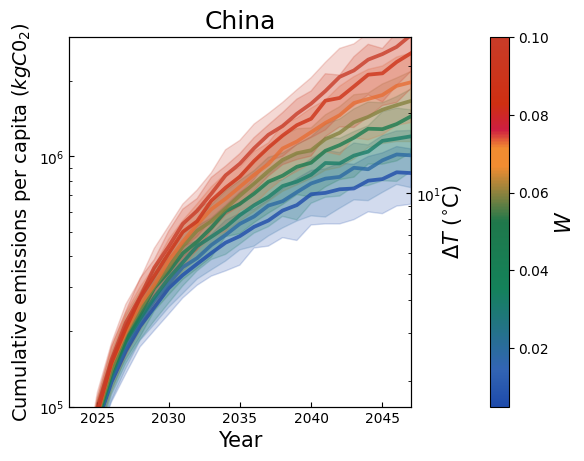

In [ ]:
## Predicted cumulative emissions varying growth rate ##
country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, True #True to show temperature variation on right axis, True to use a logscale for y axis

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

# Rescale all lists to have the same size
Emperyearlist = Emperyearlist[-duration:] 
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1]
rho = np.mean(rholist)
meanW = np.mean(np.log(1.+rlist))
sigW = np.std(np.log(1.+rlist))
inidebt = debtpercapitalist[0]
Emintensitylist = Emperyearlist/GDPpercapitalist
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0]

Wlist = np.linspace(0.005,0.1, 8) #List of W (growth rate) values to study

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy() #Update color list
cdeb.reverse() #Update colorlist
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy() #Update colorlist
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[6]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap
norm = mpl.colors.Normalize(vmin=Wlist[0], vmax=Wlist[-1], clip=False)

rep = 100 #Number of repetitions
avgEm = [0. for _ in range(len(Wlist))] #Initiate average emissions list
stdsqr = [np.zeros(tflist.size) for _ in range(len(Wlist))] #Initiate standard deviation list
for i in range(rep):
    for j,W in enumerate(Wlist):
        model = kelly_debt(5, np.average(levlist), GDP0, 100, rho, 50, gaussian=True, W = W, sig=sigW, borroweachstep=True) #Stochastic model
        emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True)[0] for tf in tflist])
        avgEm[j] += emissions #Update average emissions
        stdsqr[j] += np.array([(emissions[tf] - avgEm[j][tf]/(i+(i==0)))**2 for tf in tflist]) #Update standard deviation
avgEm = [em/rep for em in avgEm]
stdsqr = [np.sqrt(st/rep) for st in stdsqr]
for j,L in enumerate(Levlist):
    ax1.plot(2023+tflist, avgEm[j], lw = 2.7, alpha = 0.8, c=cmapphase((L-1)/(Levlist[-1]-1)), label=r'$W = {}$'.format(str(W)[:5]))
    ax1.fill_between(2023+tflist, avgEm[j] - stdsqr[j], avgEm[j] + stdsqr[j], color=cmapphase((L-1)/(Levlist[-1]-1)), alpha=0.2)

ylimmin, ylimmax = 1E5, 3E6
cbar = fig1.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmapphase), ax=ax1, label=r'$W$', pad=0.16)
cbar.set_label(r'$W$', size=15)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgC0_2$)', fontsize=14)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(str.upper(country[0]) + country[1:], fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_grate'+country+'.pdf')

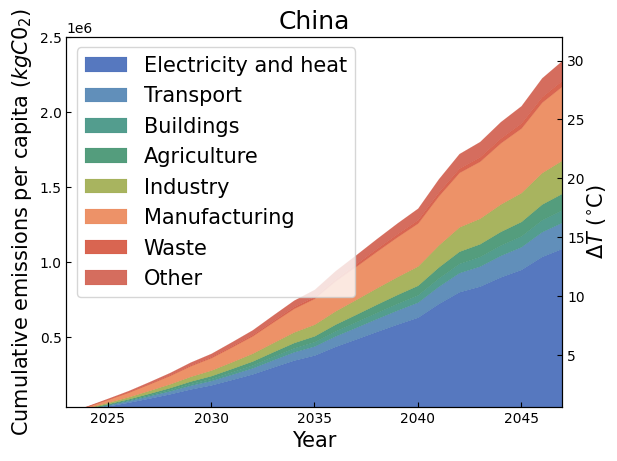

In [30]:
## Predicted emissions per sector ##
country = "china" #Pick the country among US, china, denmark, france
duration = 25 #Duration in years
firstyear = 2022 - duration #Starting year for the study
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1

temp, logscale = True, False

Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
firstyear = 1960 + GDPpercapitalist.size-duration

#Starting year for the study
Emperyearlist = Emperyearlist[-duration:]
GDPpercapitalist = GDPpercapitalist[-duration:]
debtpercapitalist = debtpercapitalist[-duration:]
poplist = poplist[-duration:]
deficitpercapitalist = deficitpercapitalist[-duration:]

gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

##Initial conditions##
GDP0 = GDPpercapitalist[-1] #Initial GDP per capita
rho = np.mean(rholist) #Average interest rate
meanW = np.mean(np.log(1.+rlist)) #Mean of the log of the implicit growth rate
sigW = np.std(np.log(1.+rlist)) #Standard deviation of the log of the implicit growth rate
inidebt = debtpercapitalist[0] #Initial debt per capita
Emintensitylist = Emperyearlist/GDPpercapitalist #Emissions intensity list, from 0 to duration-1
gamma, I0 = -(Emintensitylist[-1] - Emintensitylist[0])/Emintensitylist.size, Emintensitylist[0] #Linear parameters for the emissions intensity

L = 1.02 #Average leverage, can be changed to study different leverage values

title = r'Leverage and $CO_2$ emissions in ' + 'the US' if country=='US' else '' + str.upper(country[0]) + country[1:]
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
if temp:
    ax2 = ax1.twinx()
    ax2.yaxis.tick_right()
    ax2.yaxis.set_tick_params(direction='in', which='both')
    ax2.set_ylabel(r'$\Delta T$ ($^{\circ}$C)', fontsize=15, labelpad=0)
cdeb = list(carr[7:12]).copy()
cdeb.reverse()
clist = (cdeb+list(carr[:2])+list(carr[1:5])+list(carr[14:])).copy()
clist = [(0, clist[1]), (0.1, clist[2]), (0.32, clist[3]),  (0.5, clist[4]), (0.65, clist[5]), (0.7, clist[7]), (0.75, clist[8]), (0.82, clist[9]), (1., clist[10])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

rep = 100 #Number of repetitions
avgEm = 0. #Initiate average emissions
for i in range(rep):
    model = kelly_debt(5, L, GDP0, 100, rho, 50, rhoclose=True, gaussian=True, W = meanW, sig=sigW, borroweachstep=True)
    emissions = np.array([model.emissions(firstyear+tf, Emintensitylist, firstyear, predic = True)[0] for tf in tflist])
    avgEm += emissions
avgEm = avgEm/rep

#for US
repart_sectors = np.load(cd + '/data/repart_sectors_'+country+'.npy')

sector_title = ['Electricity and heat', 'Transport', 'Buildings', 'Agriculture', 'Industry', 'Manufacturing', 'Waste', 'Other']
for j in range(len(repart_sectors)):
    x0, x1 = sum(repart_sectors[:j]), sum(repart_sectors[:j+1])
    ax1.fill_between(2023+tflist, x0*avgEm, x1*avgEm, lw = .1, alpha = 0.75, color=cmapphase(j/(len(repart_sectors)-1)), label=sector_title[j])

ax1.legend(fontsize=15, loc='upper left')
ylimmin, ylimmax = 4E4, 2.5E6
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'Cumulative emissions per capita ($kgC0_2$)', fontsize=15)
ax1.margins(x=0)
if logscale:
    ax1.set_yscale('log')
if temp:
    if logscale:
        ax2.set_yscale('log')
    worldpop = 8E9
    ax2.set_ylim(ylimmin*1.6*1E-5, ylimmax*1.6*1E-15*worldpop)
ax1.set_xlim(2023+tflist[0],2023+tflist[-1])
ax1.set_ylim(ylimmin,ylimmax)
ax1.set_title(title, fontsize=18)
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/emissions_pred_persector'+country+'.pdf')

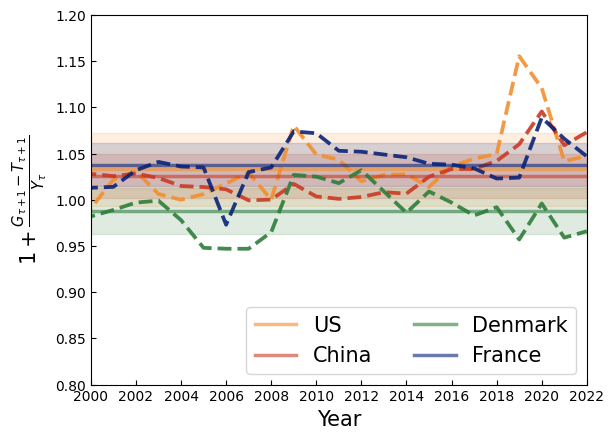

In [2]:
## Study Primary Deficit_{t+1}/GDP_{t} ratio ##

## GDP and Debt ##

countries = ['US', 'china', 'denmark', 'france']
duration = 25 #Duration in years

title = r'Primary deficit to GDP'
fig1 = plt.figure() 
ax1 = fig1.add_subplot(111)
clist = carr[:13].copy()
clist = [(0, clist[0]), (0.05, clist[1]), (0.1, clist[2]), (0.2, clist[3]), (0.32, clist[4]), (0.4, clist[5]), (0.5, clist[6]), (0.6, clist[7]), (0.65, clist[8]), (0.7, clist[9]), (0.75, clist[10]), (0.82, clist[11]), (1., clist[12])] #[(i*1/11., clist[i]) for i in range(len(clist))]
cmapphase = LinearSegmentedColormap.from_list('cmap', clist) #Create the colormap

for n, country in enumerate(countries):
    Emperyearlist = np.load(cd + '/data/Emperyearlist_'+country+'.npy') #Yearly emissions per capita data
    GDPpercapitalist = np.load(cd + '/data/GDPpercapita_'+country+'.npy') #GDP per capita data
    debtpercapitalist = np.load(cd + '/data/debtpercapita_'+country+'.npy') #Debt per capita data
    poplist = np.load(cd + '/data/pop_'+country+'.npy') #Population data
    deficitpercapitalist = np.load(cd + '/data/deficitpercapita_'+country+'.npy') #Deficit per capita data
    tflist=np.array(range(duration)) #Time frame list, from 0 to duration-1
    firstyear = 1960 + GDPpercapitalist.size-duration #Starting year for the study

    # Rescale all lists to have the same size
    Emperyearlist = Emperyearlist[-duration:]
    GDPpercapitalist = GDPpercapitalist[-duration:]
    debtpercapitalist = debtpercapitalist[-duration:]
    poplist = poplist[-duration:]
    deficitpercapitalist = deficitpercapitalist[-duration:]

    gratelist = [GDPpercapitalist[i] / GDPpercapitalist[i - 1] for i in range(1, len(GDPpercapitalist))] #Growth rate list, from 1 to duration-1
    levlist = deficitpercapitalist / GDPpercapitalist + 1. #Leverage list, from 1 to duration-1
    rlist = np.array(gratelist) - 1. - deficitpercapitalist[1:] / GDPpercapitalist[1:] #Implicit growth rate list from 1 to duration-1
    rholist = np.array([(debtpercapitalist[i+1] - (levlist[i]-1)*GDPpercapitalist[i])/debtpercapitalist[i] for i in range(len(rlist)-1)]) #Interest rate list from 1 to duration-2

    ax1.plot(firstyear+tflist, levlist, lw = 2.7, alpha = 0.9, ls='--', c=cmapphase(n/4+0.05)) #Plot data
    ax1.plot(firstyear+tflist, [np.average(levlist) for _ in firstyear+tflist], lw = 2.5, alpha = 0.6, ls='-',
     c=cmapphase(n/4+0.05), label= 'US' if country == 'US' else str.upper(country[0]) + country[1:]) #Plot average
    ax1.fill_between(firstyear+tflist, [np.average(levlist)-np.std(levlist) for _ in firstyear+tflist],
     [np.average(levlist)+np.std(levlist) for _ in firstyear+tflist], alpha = 0.15, color=cmapphase(n/4+0.05)) #Plot standard deviation

ylimmin, ylimmax = 0.8, 1.2
ax1.set_xlim(firstyear + 2, 2022)
ax1.set_ylim(ylimmin, ylimmax)

ax1.legend(fontsize=15, loc='lower right', ncols = 2)
ax1.set_xlabel(r'Year', fontsize=15)
ax1.set_ylabel(r'$1+\frac{G_{\tau+1}-T_{\tau+1}}{Y_{\tau}}$', fontsize=15)
ax1.margins(x=0)
ax1.set_xticks([firstyear+i for i in range(2, duration+1, 2)])
ax1.tick_params(direction='in', which='both')
fig1.savefig(cd + '/results/primarydeficit_to_gdp_all.pdf')